In [21]:
# Importing neccessary libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
import numpy as np
import deeplake as dl
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [22]:
# Loading in Datasets
train_ds = dl.load('hub://activeloop/gtsrb-train')
test_ds = dl.load('hub://activeloop/gtsrb-test')
print(train_ds.summary())
train_shape = train_ds.images[0].shape
print(f"Image Shape: {train_shape}")

/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-train



/

hub://activeloop/gtsrb-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-test



/

hub://activeloop/gtsrb-test loaded successfully.



Dataset(path='hub://activeloop/gtsrb-train', read_only=True, tensors=['images', 'boxes', 'labels', 'shapes', 'colors'])

 tensor      htype               shape              dtype  compression
 -------    -------             -------            -------  ------- 
 images      image     (39209, 25:225, 25:243, 3)   uint8    jpeg   
  boxes      bbox            (39209, 1, 4)         float32   None   
 labels   class_label          (39209, 1)          uint32    None   
 shapes   class_label          (39209, 1)          uint32    None   
 colors   class_label          (39209, 1)          uint32    None   
None
Image Shape: (26, 26, 3)


In [23]:
# Resizing Images
def resize_images(images):
    resized = tf.image.resize(images, (26, 26)).numpy()
    normalized = resized / 255.0
    return normalized
train_images, test_images = train_ds.images.numpy(aslist=True), test_ds.images.numpy(aslist=True)
train_labels, test_labels = train_ds.labels.numpy().squeeze(), test_ds.labels.numpy().squeeze()

train_images_resized = np.array([resize_images(img) for img in train_images])
test_images_resized = np.array([resize_images(img) for img in test_images])

In [30]:
# Create and Train Model
def create_train_model(images, labels):
    model = keras.Sequential([
        layers.Input(shape=(26, 26, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(43, activation='softmax')
    ])
    lr_scheduler = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        alpha=0.0)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.fit(images, labels, epochs=15, batch_size=128)
    return model
traffic_sign_model = create_train_model(train_images_resized, train_labels)

Epoch 1/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7271 - loss: 1.1068
Epoch 2/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9576 - loss: 0.2004
Epoch 3/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9816 - loss: 0.0918
Epoch 4/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9891 - loss: 0.0548
Epoch 5/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9935 - loss: 0.0350
Epoch 6/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9951 - loss: 0.0248
Epoch 7/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9972 - loss: 0.0170
Epoch 8/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9979 - loss: 0.0128
Epoch 9/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9987 - loss: 0.0095
Epoch 10/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9995 - loss: 0.0064
Epoch 11/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9995 - loss: 0.0050
Epoch 12/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 

In [31]:
# Evaluating Model with Test Data
def evaluate_model(model, images, labels):
    loss, accuracy = model.evaluate(images, labels)
    loss, accuracy = np.round((loss, accuracy), 4) * 100
    print(f"Loss: {loss} Accuracy: {accuracy}")
evaluate_model(traffic_sign_model, test_images_resized, test_labels)

230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9315 - loss: 0.3379
Loss: 33.79 Accuracy: 93.15


In [36]:
# Evaluating Latency Data
def evaluate_latency(model, images, num_samples=500):
    warmup_images = images[:20]
    measurement_images = images[20:20 + num_samples]
    for image in warmup_images:
        _ = model.predict(np.expand_dims(image, axis=0), verbose=0)
    time_records = []
    for image in measurement_images:
        sample = np.expand_dims(image, axis=0)
        start_time = time.monotonic()
        _ = model.predict(sample, verbose=0)
        end_time = time.monotonic()
        inference_time = (end_time - start_time) * 1000
        time_records.append(inference_time)
    return time_records
latency_records = evaluate_latency(traffic_sign_model, test_images_resized)

# Statistical Analysis of Latency
print(f"Average Latency: {np.round(np.mean(latency_records), 2)} ms")
print(f"Min Latency: {np.round(np.min(latency_records), 2)} ms")
print(f"Max Latency: {np.round(np.max(latency_records), 2)} ms")
print(f"Standard Deviation: {np.round(np.std(latency_records), 2)} ms")
print(f"Median Latency: {np.round(np.median(latency_records), 2)} ms")
print(f"99th Percentile Latency: {np.round(np.percentile(latency_records, 99), 2)} ms")
print(f"90th Percentile Latency: {np.round(np.percentile(latency_records, 90), 2)} ms")

Average Latency: 55.87 ms
Min Latency: 31.0 ms
Max Latency: 125.0 ms
Standard Deviation: 10.59 ms
Median Latency: 47.0 ms
99th Percentile Latency: 79.0 ms
90th Percentile Latency: 63.0 ms


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


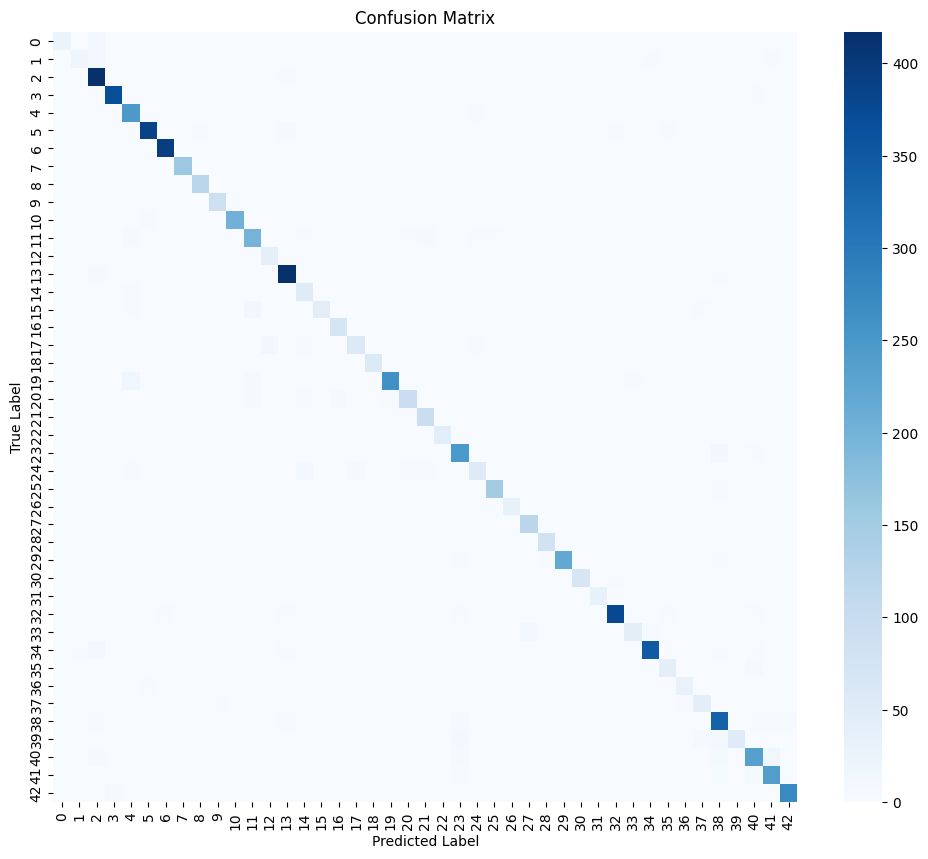

In [ ]:
# Confusion Matrix Visualization
import seaborn as sns
y_pred = traffic_sign_model.predict(test_images_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()